In [45]:
from Regression import Regression
from Franke import FrankeCentered, FrankeCenteredNoise

import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn
from sklearn.metrics import mean_squared_error as MSE
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split, KFold
from sklearn.linear_model import Lasso
import scipy.stats
import time
from imageio import imread
from tqdm import tqdm, trange

mpl.style.use("seaborn-darkgrid")
mpl.rcParams["image.cmap"] = "gnuplot2"
mpl.rcParams['figure.figsize'] = [6.0, 6.0]
mpl.rcParams["font.size"] = 18
mpl.rcParams["lines.linewidth"] = 3

np.random.seed(1942)

# 1 **Set up**

In [2]:
x, y = np.linspace(-1, 1, 101), np.linspace(-1, 1, 101)
reg = Regression()
reg.generate_generic_data(x, y, FrankeCenteredNoise)

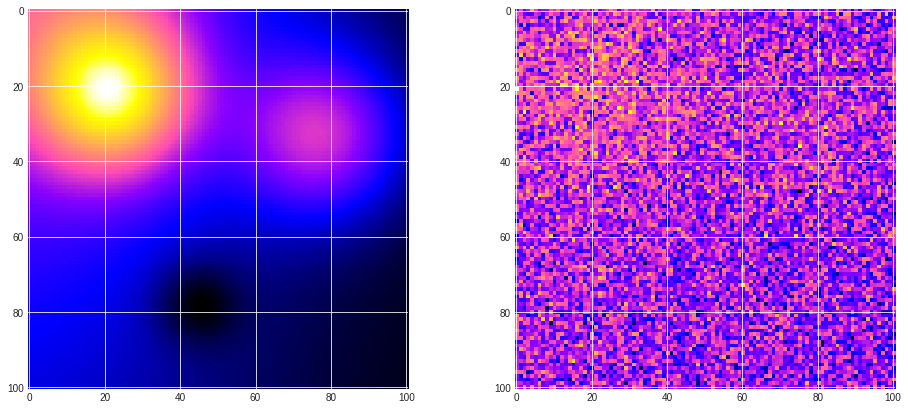

In [3]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 7))
franke_noiseless = FrankeCentered(reg.x_mesh, reg.y_mesh)
ax1.imshow(franke_noiseless);
ax2.imshow(reg.f);

# 2. **OLS**

fitting 

In [50]:
beta_ols = reg.solveCoefficients(poly_order=5, solver="OLS")
data_pred_ols = reg.apply_model(beta_ols, reg.x_mesh, reg.y_mesh)

**Error**

In [51]:
mse = MSE(reg.f, data_pred_ols)
#rmse = np.sqrt(mse)
#rrmse = rmse/np.mean(reg.f)
r2 = r2_score(reg.f, data_pred_ols)
print("metrics vs noisy franke (data trained on): ", mse, r2)

mse = MSE(franke_noiseless, data_pred_ols)
#rmse = np.sqrt(mse)
#rrmse = rmse/np.mean(reg.f)
r2 = r2_score(franke_noiseless, data_pred_ols)
print("metrics vs noiseless franke: ", mse, r2)


metrics vs noisy franke (data trained on):  0.9967444998114317 0.04738438341079331
metrics vs noiseless franke:  0.003855795102156338 0.8342100404884103


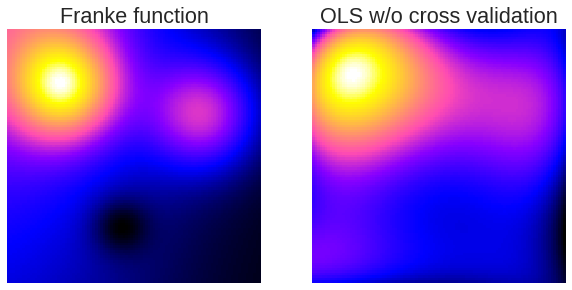

In [53]:
fig, axs = plt.subplots(1,2,figsize=(10,10))
axs[0].imshow(franke_noiseless)
axs[0].set_title("Franke function")
axs[0].axis("off")
axs[1].imshow(data_pred_ols)
axs[1].set_title("OLS w/o cross validation")
axs[1].axis("off")
fig.tight_layout;
plt.savefig("../figs/franke_vs_ols_nocross.pdf", bbox_inches="tight")

# 3. **OLS K-FOLDING**

In [6]:
data_pred_Kfolding = reg.solveKFold(K=10, poly_order=5, solver="OLS")

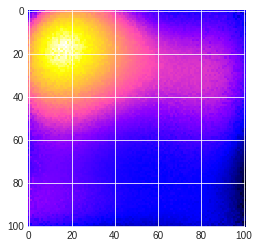

In [7]:
plt.imshow(data_pred_Kfolding)

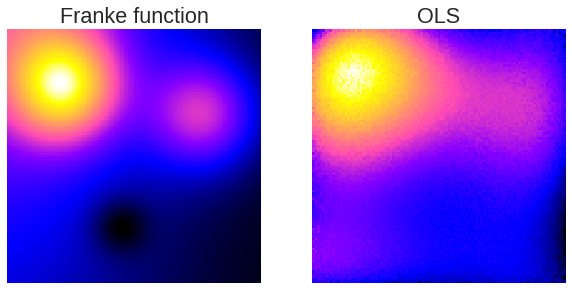

In [54]:
fig, axs = plt.subplots(1,2,figsize=(10,10))
axs[0].imshow(franke_noiseless)
axs[0].set_title("Franke function")
axs[0].axis("off")
axs[1].imshow(data_pred_Kfolding)
axs[1].set_title("OLS")
axs[1].axis("off")
fig.tight_layout;
plt.savefig("../figs/franke_vs_ols.pdf", bbox_inches="tight")

In [9]:
mse_ols = MSE(reg.f, data_pred_Kfolding)
#rmse_ols = np.sqrt(mse_ols)
r2_ols = r2_score(reg.f, data_pred_Kfolding)
print("mse, rmse and r2 score for k-folding with k=10", mse_ols,r2_ols)

mse_ols_n = MSE(franke_noiseless, data_pred_Kfolding)
#rmse_ols_n = np.sqrt(mse)
r2_ols_n = r2_score(franke_noiseless, data_pred_Kfolding)
print("metrics vs noiseless franke: ", mse_ols_n, r2_ols_n)

mse, rmse and r2 score for k-folding with k=10 1.001007909744197 0.04341263708400598
metrics vs noiseless franke:  0.004149800914642737 0.820304458544211


**Solving for different values of K**

In [10]:
data_pred_list = []
for i in trange(5, 50, 2):
    K = i
    data_pred = reg.solveKFold(K=K, poly_order=5, solver="OLS")
    data_pred_list.append(data_pred)

100%|██████████| 23/23 [00:11<00:00,  1.98it/s]


In [11]:
mse_list = []
mse_list_noiseless = []
r2_list = []
r2_list_noiseless = []
for i in range(len(data_pred_list)):
    data_pred = data_pred_list[i]
    mse_list.append(MSE(reg.f, data_pred))
    mse_list_noiseless.append(MSE(franke_noiseless, data_pred))
    r2_list.append(r2_score(reg.f, data_pred))
    r2_list_noiseless.append(r2_score(franke_noiseless, data_pred))

**MSE and R2-plots for different values of K**

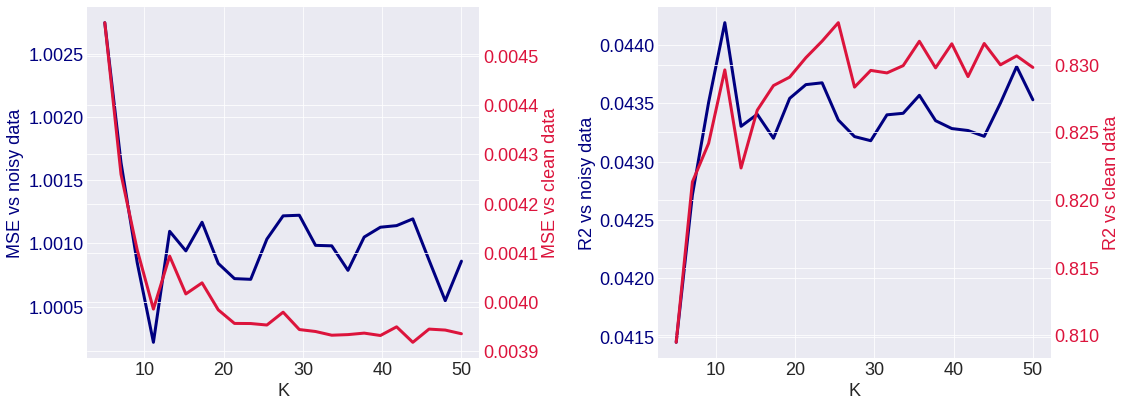

In [46]:
n = len(mse_list)
k = np.linspace(5,50,n)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
ax11 = ax1.twinx(); ax22 = ax2.twinx()
ax1.plot(k,mse_list, c = "navy", label="noisy data");
ax11.plot(k,mse_list_noiseless, c="crimson", label="noiseless data")
ax1.set_xlabel("K")
ax1.set_ylabel("MSE vs noisy data", color="navy");
ax11.set_ylabel("MSE vs clean data", color="crimson");
ax1.tick_params(axis='y', labelcolor="navy")
ax11.tick_params(axis='y', labelcolor="crimson")

ax2.plot(k,r2_list, c="navy", label="noisy data");
ax22.plot(k,r2_list_noiseless, c="crimson", label="noiesless data")
ax2.set_xlabel("K")
ax2.set_ylabel("R2 vs noisy data", color="navy");
ax22.set_ylabel("R2 vs clean data", color="crimson");
ax2.tick_params(axis='y', labelcolor="navy")
ax22.tick_params(axis='y', labelcolor="crimson")
fig.tight_layout()

**K-FOLD MEAN**

**RIDGE**

In [13]:
data_pred_ridge = reg.solveKFold(K=10, poly_order=5, solver="Ridge")

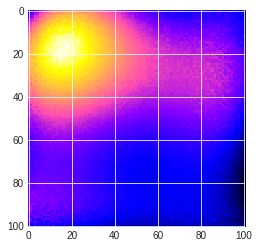

In [14]:
plt.imshow(data_pred_ridge);

In [15]:
mse_list_ridge = []
mse_list_noiseless_ridge = []
r2_list_ridge = []
r2_list_noiseless_ridge = []
lamda_list_ridge = np.logspace(3, -8, 16)
for i in trange(len(lamda_list_ridge)):
    lamda = lamda_list_ridge[i]
    data_pred = reg.solveKFold(K=10, poly_order=5, solver="Ridge", lamda=lamda)
    mse_list_ridge.append(MSE(reg.f, data_pred))
    mse_list_noiseless_ridge.append(MSE(franke_noiseless, data_pred))
    r2_list_ridge.append(r2_score(reg.f, data_pred))
    r2_list_noiseless_ridge.append(r2_score(franke_noiseless, data_pred))

100%|██████████| 16/16 [00:04<00:00,  3.60it/s]


**Plots showing how the error behaves for increasing values of Lambda** 

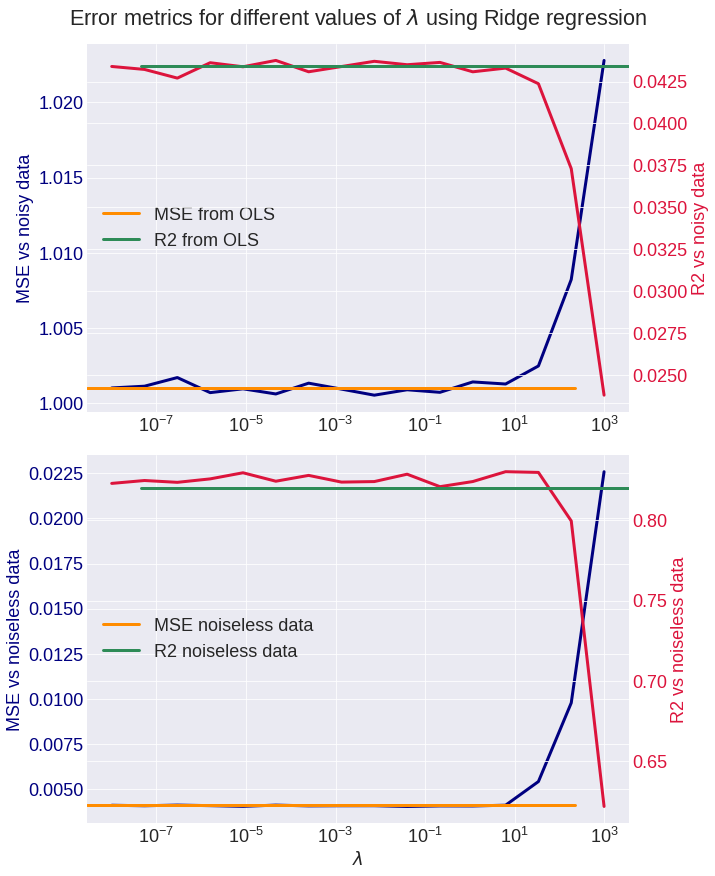

In [47]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10,12))
ax11 = ax1.twinx(); ax22 = ax2.twinx()
ax1.semilogx(lamda_list_ridge, mse_list_ridge, c="navy");
ax11.semilogx(lamda_list_ridge, r2_list_ridge, c="crimson");


ax2.semilogx(lamda_list_ridge, mse_list_noiseless_ridge, c="navy")
ax22.semilogx(lamda_list_ridge, r2_list_noiseless_ridge, c="crimson")


line1 = ax1.axhline(y=mse_ols, xmin=0.0, xmax=0.9, color='darkorange',label="MSE from OLS")
line2 = ax11.axhline(y=r2_ols, xmin=0.1, xmax=1.0, color='seagreen', label="R2 from OLS")
line3 = ax2.axhline(y=mse_ols_n, xmin = 0.0, xmax = 0.9, color='darkorange', label="MSE noiseless data")
line4 = ax22.axhline(y=r2_ols_n, xmin = 0.1, xmax = 1.0, color='seagreen', label="R2 noiseless data")

ax1.legend((line1,line2), ("MSE from OLS", "R2 from OLS"), loc = 6)
ax2.legend((line3, line4), ("MSE noiseless data", "R2 noiseless data"), loc = 6)

#ax1.set_xlabel(r"$\lambda$")
ax1.set_ylabel("MSE vs noisy data", color="navy");
ax11.set_ylabel("R2 vs noisy data", color="crimson")
ax1.tick_params(axis='y', labelcolor="navy")
ax11.tick_params(axis='y', labelcolor="crimson")
ax2.set_xlabel(r"$\lambda$")
ax2.set_ylabel("MSE vs noiseless data", color="navy");
ax22.set_ylabel("R2 vs noiseless data", color="crimson")
ax2.tick_params(axis='y', labelcolor="navy")
ax22.tick_params(axis='y', labelcolor="crimson")
fig.suptitle("Error metrics for different values of $\lambda$ using Ridge regression", y=1.02)
fig.tight_layout()
plt.savefig("../figs/errormetrics_lambda_ridge_franke.pdf", bbox_inches="tight")

In [17]:
reg.solveCoefficients(solver="Ridge")

array([ 0.33645234, -0.76856351,  0.3294267 ,  1.07640302, -0.49997075,
       -0.46388726, -0.20174887,  0.61605123, -0.92134816, -0.20322165,
        0.67178533,  0.5841824 , -0.41818721, -0.02432639,  0.14593933,
        0.12684374, -0.48795694,  0.33318717, -0.67382068,  0.40477772,
       -0.08649317])

**LASSO**

In [18]:
data_pred_lasso = reg.solveKFold(K=10,poly_order=5,solver='Lasso')

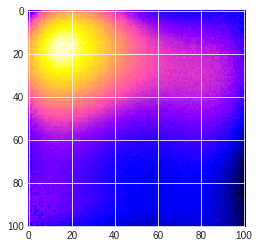

In [19]:
plt.imshow(data_pred_lasso)

In [20]:
mse = MSE(reg.f, data_pred_lasso)
rmse = np.sqrt(mse)
r2 = r2_score(reg.f, data_pred_lasso)
print("mse, rmse and r2 score for lasso,", mse, rmse, r2)

mse, rmse and r2 score for lasso, 1.0008647998982796 1.0004323065046827 0.04357809043597931


In [21]:
reg.solveCoefficients(solver="Lasso")

array([ 0.34402849, -0.74411383,  0.29760094,  0.91309968, -0.4714934 ,
       -0.31201955, -0.1940432 ,  0.59124115, -0.81698933, -0.18365595,
        0.5880316 ,  0.55235721, -0.31522115, -0.00602435,  0.09979572,
        0.03836918, -0.46839159,  0.28569944, -0.64534395,  0.32158216,
       -0.        ])

In [22]:
data_pred_lasso_comparison = reg.solveKFold(K=10, poly_order=5, solver='Lasso')

In [23]:
mse_list_lasso = []
mse_list_noiseless_lasso = []
r2_list_lasso = []
r2_list_noiseless_lasso = []
lamda_list_lasso = np.logspace(-2, -8, 16)
for i in trange(len(lamda_list_lasso)):
    lamda = lamda_list_lasso[i]
    data_pred = reg.solveKFold(K=10, poly_order=5, solver="Lasso", lamda=lamda)
    mse_list_lasso.append(MSE(reg.f, data_pred))
    mse_list_noiseless_lasso.append(MSE(franke_noiseless, data_pred))
    r2_list_lasso.append(r2_score(reg.f, data_pred))
    r2_list_noiseless_lasso.append(r2_score(franke_noiseless, data_pred))

100%|██████████| 16/16 [01:03<00:00,  3.97s/it]


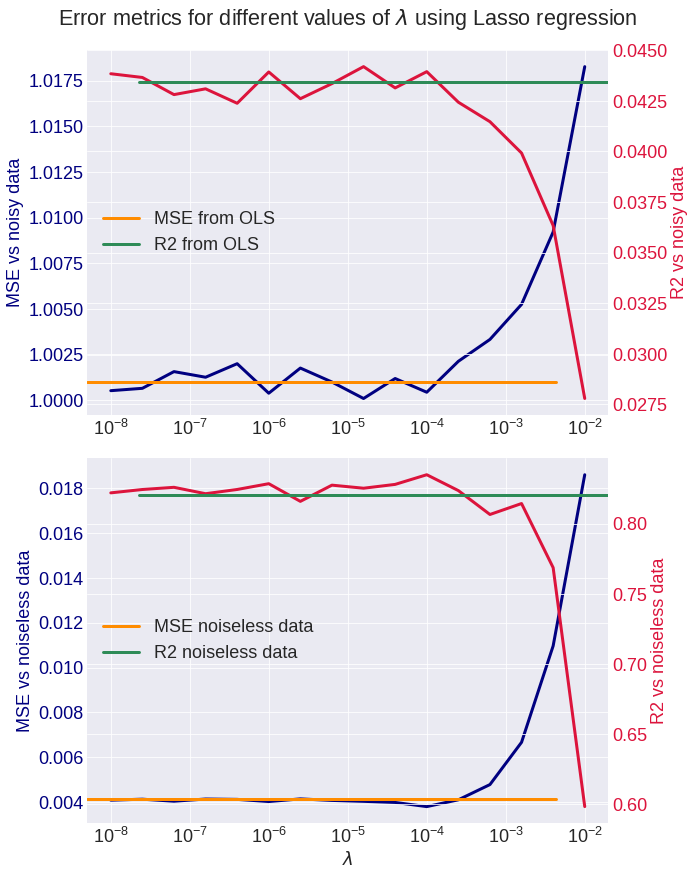

In [48]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10,12))
ax11 = ax1.twinx(); ax22 = ax2.twinx()
ax1.semilogx(lamda_list_lasso, mse_list_lasso, c="navy");
ax11.semilogx(lamda_list_lasso, r2_list_lasso, c="crimson");


ax2.semilogx(lamda_list_lasso, mse_list_noiseless_lasso, c="navy")
ax22.semilogx(lamda_list_lasso, r2_list_noiseless_lasso, c="crimson")


line1 = ax1.axhline(y=mse_ols, xmin=0.0, xmax=0.9, color='darkorange',label="MSE from OLS")
line2 = ax11.axhline(y=r2_ols, xmin=0.1, xmax=1.0, color='seagreen', label="R2 from OLS")
line3 = ax2.axhline(y=mse_ols_n, xmin = 0.0, xmax = 0.9, color='darkorange', label="MSE noiseless data")
line4 = ax22.axhline(y=r2_ols_n, xmin = 0.1, xmax = 1.0, color='seagreen', label="R2 noiseless data")

ax1.legend((line1,line2), ("MSE from OLS", "R2 from OLS"), loc = 6)
ax2.legend((line3, line4), ("MSE noiseless data", "R2 noiseless data"), loc = 6)

#ax1.set_xlabel(r"$\lambda$")
ax1.set_ylabel("MSE vs noisy data", color="navy");
ax11.set_ylabel("R2 vs noisy data", color="crimson")
ax1.tick_params(axis='y', labelcolor="navy")
ax11.tick_params(axis='y', labelcolor="crimson")
ax2.set_xlabel(r"$\lambda$")
ax2.set_ylabel("MSE vs noiseless data", color="navy");
ax22.set_ylabel("R2 vs noiseless data", color="crimson")
ax2.tick_params(axis='y', labelcolor="navy")
ax22.tick_params(axis='y', labelcolor="crimson")
fig.suptitle("Error metrics for different values of $\lambda$ using Lasso regression", y=1.02)
fig.tight_layout()
plt.savefig("../figs/errormetrics_lambda_lasso_franke.pdf", bbox_inches="tight")

**Errors for optimal values of lambda in both Ridge and Lasso compared with regular OLS**

In [25]:
data_pred_ridge_optimal = reg.solveKFold(K=10, poly_order=5, lamda = 1e-1, solver="Ridge")
data_pred_lasso_optimal = reg.solveKFold(K=10,poly_order=5, lamda = 1e-5, solver='Lasso')

In [26]:
MSE_ridge_optimal = MSE(reg.f, data_pred_ridge_optimal)
R2_ridge_optimal = r2_score(reg.f, data_pred_ridge_optimal)

MSE_ridge_optimal_n = MSE(franke_noiseless, data_pred_ridge_optimal)
R2_ridge_optimal_n = r2_score(franke_noiseless, data_pred_ridge_optimal)

MSE_lasso_optimal = MSE(reg.f, data_pred_lasso_optimal)
R2_lasso_optimal = r2_score(reg.f, data_pred_lasso_optimal)

MSE_lasso_optimal_n = MSE(franke_noiseless, data_pred_lasso_optimal)
R2_lasso_optimal_n = r2_score(franke_noiseless, data_pred_lasso_optimal)

#mse_ols, mse_ols_n, r2_ols, r2_ols_n

print("MSE and R2 score for optimal lambda in Ridge method compared to noisy data =", MSE_ridge_optimal, R2_ridge_optimal)
print("MSE and R2 score for optimal lambda in Ridge method compared to noiseless data=", MSE_ridge_optimal_n, R2_ridge_optimal_n)

print("\n")

print("MSE and R2 score for optimal lambda in Lasso method compared to noisy data =", MSE_lasso_optimal, R2_lasso_optimal)
print("MSE and R2 score for optimal lambda in Lasso method compared to noiseless data=", MSE_lasso_optimal_n, R2_lasso_optimal_n)

print("\n")

print("MSE and R2 score for optimal lambda in OLS method compared to noisy data =", mse_ols, r2_ols)
print("MSE and R2 score for optimal lambda in OLS method compared to noiseless data=", mse_ols_n, r2_ols_n)

MSE and R2 score for optimal lambda in Ridge method compared to noisy data = 1.0008958802471042 0.04346087372096782
MSE and R2 score for optimal lambda in Ridge method compared to noiseless data= 0.004055725107148094 0.8259805327722665


MSE and R2 score for optimal lambda in Lasso method compared to noisy data = 1.000690546555348 0.04363153131422793
MSE and R2 score for optimal lambda in Lasso method compared to noiseless data= 0.004071551772973781 0.8268564409651676


MSE and R2 score for optimal lambda in OLS method compared to noisy data = 1.001007909744197 0.04341263708400598
MSE and R2 score for optimal lambda in OLS method compared to noiseless data= 0.004149800914642737 0.820304458544211


# PRED IMAGES VS FIT IMAGES

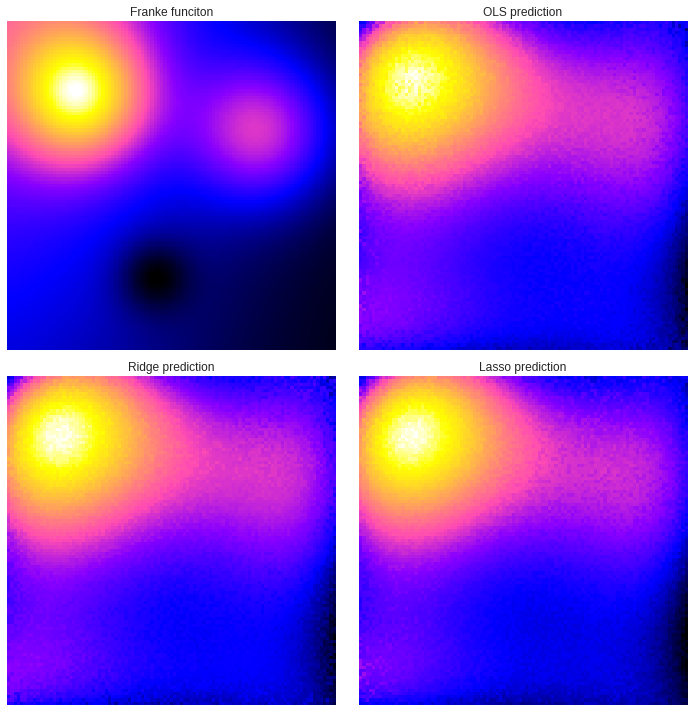

In [27]:
fig, axs = plt.subplots(2,2, figsize=(10,10))

axs[0,0].imshow(franke_noiseless)
axs[0,0].set_title("Franke funciton")
axs[0,0].axis("off")
axs[0,1].imshow(data_pred_Kfolding)
axs[0,1].set_title("OLS prediction")
axs[0,1].axis("off")
axs[1,0].imshow(data_pred_ridge_optimal)
axs[1,0].set_title("Ridge prediction")
axs[1,0].axis("off")
axs[1,1].imshow(data_pred_lasso_optimal)
axs[1,1].set_title("Lasso prediction")
axs[1,1].axis("off")
fig.tight_layout()
plt.savefig("../figs/All_predictions_franke.pdf", bbox_inches="tight")